Alex Notebook

Import modules

In [54]:
# import the modules
import pandas as pd
from influxdb import DataFrameClient, InfluxDBClient
import pytz
import datetime
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import config

sns.set(style = "ticks")

Define df client for Pandas

In [3]:
client = DataFrameClient(host = config.DB_HOST, port = config.DB_PORT, database = config.DB_DBNAME)

Data exploration

In [17]:
#Set time relative to now for Query (today: 00:00:00)
now = datetime.datetime.today()
past = now - datetime.timedelta(days = config.days_delta)

#Set start and end time
end_time = now.strftime("%Y-%m-%d %H:%M:%S")
start_time = past.strftime("%Y-%m-%d %H:%M:%S")

# NoSQL Query  (to be added: timezone adjusting)
query = "SELECT * FROM \"{}\",\"{}\" WHERE time >= '{}' AND time <= '{}' "\
                        .format(config.stations[0], config.stations[1], start_time, end_time)

df_temp = client.query(query)

mythenquai_1y = pd.DataFrame(df_temp['mythenquai'])
mythenquai_1y.head()

tiefenbrunnen_1y = pd.DataFrame(df_temp['tiefenbrunnen'])
tiefenbrunnen_1y.head()

,air_temperature,barometric_pressure_qfe,dew_point,humidity,water_temperature,wind_direction,wind_force_avg_10min,wind_gust_max_10min,wind_speed_avg_10min,windchill
2018-11-29 17:40:00+00:00,5.8,969.3,4.3,90,9.5,299,0.9,1.7,0.9,5.8
2018-11-29 17:50:00+00:00,5.8,969.3,4.3,90,9.5,297,0.7,1.3,0.7,5.8
2018-11-29 18:00:00+00:00,5.8,969.4,4.4,91,9.5,296,0.6,1.2,0.6,5.8
2018-11-29 18:10:00+00:00,5.7,969.4,4.3,91,9.5,305,0.7,1.2,0.7,5.7
2018-11-29 18:20:00+00:00,5.6,969.3,4.3,91,9.5,300,0.8,1.6,0.8,5.6


In [ ]:
def rowindex_as_col(df, name_col):
    """add row index(time) to new column. df = dataframe, name_col = new column name"""
    df = df.index.name = name_col
    df = df.reset_index(inplace = True)
    return df

{'whiskers': [<matplotlib.lines.Line2D at 0x1d592a1f898>,
 'caps': [<matplotlib.lines.Line2D at 0x1d592a1ffd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d592a1f438>],
 'medians': [<matplotlib.lines.Line2D at 0x1d592a0c710>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d592a0ca90>],
 'means': []}

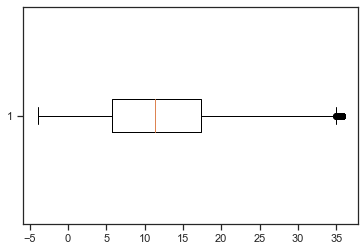

In [51]:
plt.boxplot(tiefenbrunnen_1y["air_temperature"], vert = False)

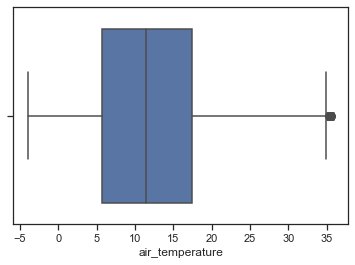

In [52]:
sns.boxplot(x = tiefenbrunnen_1y["air_temperature"])

ValueError: Grouper and axis must be same length

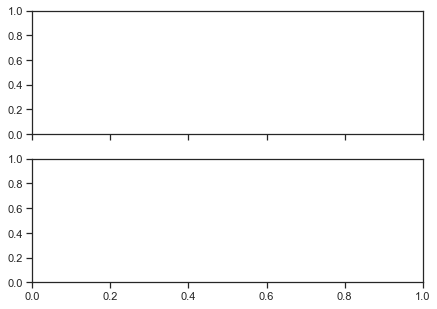

In [58]:
# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex = True)

# Generate some sequential data
x = np.array(mythenquai_1y["air_temperature"])
y1 = np.arange(0, 12)
sns.barplot(x = x, y = y1, palette = "rocket", ax = ax1)
ax1.axhline(0, color = "k", clip_on = False)
ax1.set_ylabel("Sequential")

# Finalize the plot
sns.despine(bottom = True)
plt.setp(f.axes, yticks = [])
plt.tight_layout(h_pad = 2)